## Using `contaminante` on *TESS* data

In [1]:
%%javascript
IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);

<IPython.core.display.Javascript object>

In [2]:
import contaminante as ct
import lightkurve as lk
import numpy as np

In [7]:
# from s0048-s0048:TCE1
tic, sector = 330795464, 48  # quite a few other sectors too
t0=2617.8403
duration=6.0456 / 24
period=16.968976

In [8]:
download_dir="data"  # where to store the TPFs

# one-time config for query cache if supported in the lightkurve used
if hasattr(lk.search, "sr_cache"): 
    lk.search.sr_cache.cache_dir = download_dir

tpfs_all = lk.search_targetpixelfile(f"TIC {tic}", sector=sector).download_all(download_dir=download_dir)
print("TIC sector cadence(min), num. cadence")
for t in tpfs_all:
    print(f"TIC {t.targetid}", t.sector, f"{(np.median(np.diff(t.time.value)) * 24 * 60):.0f}", len(t))

TIC sector cadence(min), num. cadence
TIC 330795464 48 2 18989


In [9]:
# filter out unhelpful tpfs (sector 22 has both 30-minute and 2-minute TPFs)
tpfs = tpfs_all
# tpfs = tpfs_all[0, 2]
tpfs_um = tpfs  # copy of tpf without additional masking

print("TIC sector cadence(min), num. cadence")
for t in tpfs:
    print(f"TIC {t.targetid}", t.sector, f"{(np.median(np.diff(t.time.value)) * 24 * 60):.0f}", len(t))

TIC sector cadence(min), num. cadence
TIC 330795464 48 2 18989


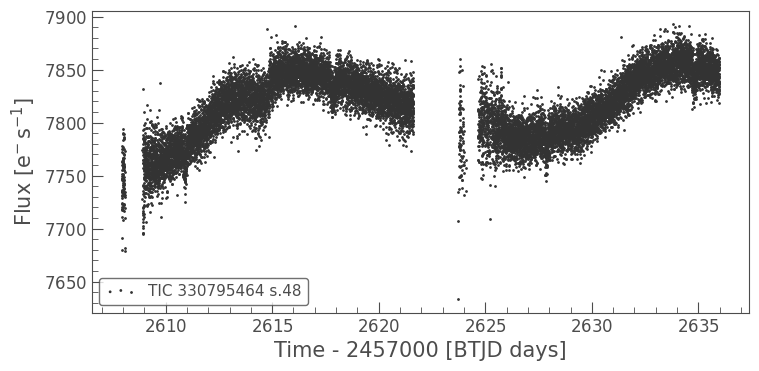

In [10]:
# Rough LCs as a reminder of what we are working with
axs = [t.to_lightcurve().remove_outliers(sigma=7).scatter(label=f"TIC {t.targetid} s.{t.sector}") for t in tpfs];

Modeling TPFs:   0%|                                                         | 0/1 [00:00<?, ?it/s]C:\dev\_juypter\contaminante\src\contaminante\contaminante.py:256: RuntimeWarning: invalid value encountered in multiply
  transit_pixels_err = np.zeros(tpf.flux.shape[1:]) * np.inf
C:\dev\_juypter\contaminante\src\contaminante\contaminante.py:257: RuntimeWarning: invalid value encountered in multiply
  chi_ratio = np.zeros(tpf.flux.shape[1:]) * np.inf
C:\dev\_juypter\contaminante\src\contaminante\contaminante.py:547: RuntimeWarning: invalid value encountered in log10
  np.log10(np.nanmedian(np.nan_to_num(tpf.flux.value), axis=0)),
Modeling TPFs: 100%|█████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.48s/it]


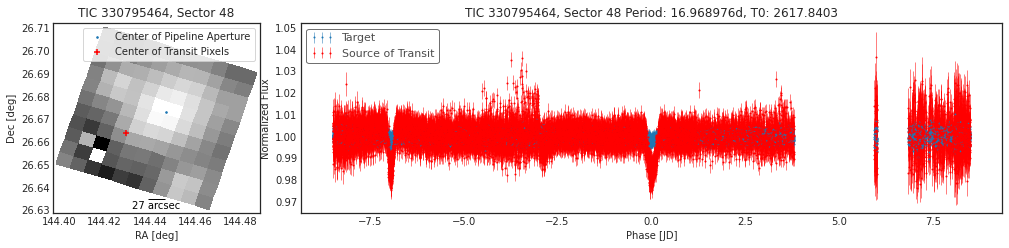

In [11]:
# Note: for TESS data, contaminate requires tpfs have been background corrected

result = ct.calculate_contamination(tpfs, period, t0, duration, plot=True,
#                                     sigma=3,  # default: 5
#                                     spline_period=0.75,  # defualt: 1
#                                     cbvs=True,  # default: True
#                                     sff=False,  # always false for TESS
                                   );

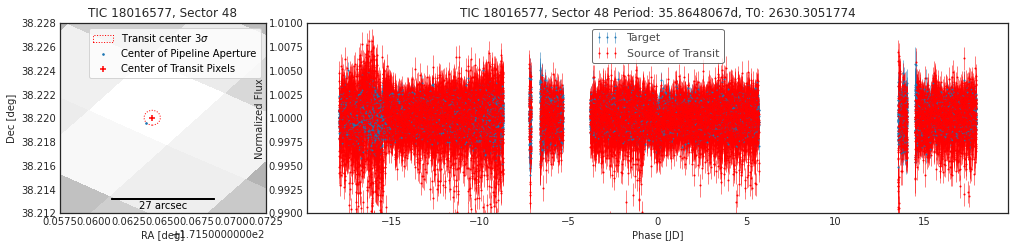

In [116]:
# To zoom in on lightcurve plot and the pixel plot

from matplotlib.patches import Ellipse
def plot_point_with_3_sigma(ax, ra_with_std, dec_with_std, label_prefix="Point"):
    ellipse = Ellipse((ra_with_std[0], dec_with_std[0]),
                      width=ra_with_std[1] * 3, height=dec_with_std[1] * 3,
                      edgecolor='red', fill=False, linestyle=':', linewidth=1,
                      label=label_prefix + r' $3\sigma$',
                     )
    ax.add_patch(ellipse)
    ax.legend()

    
ax0 = result[-1]["fig"].axes[0]
ax0.set_xlim(171.5575, 171.5725)
ax0.set_ylim(38.212, 38.228)

plot_point_with_3_sigma(ax0, result[-1]["contaminator_ra"], result[-1]["contaminator_dec"], "Transit center")

result[-1]["fig"].axes[1].set_ylim(0.97, 1.02)
result[-1]["fig"]

#### Estimate the position of the nearby TIC 330795465

- Plot the target (blue) and the nearby contamination candidate TIC 330795465 together (black), using the coordinates from ExoFOP.
- While they don't match the apeture center (grey dot)  and transit center (red plus) identified by `contaminante`, the relative positions are comparable.

C:\dev\_juypter\contaminante\src\contaminante\contaminante.py:547: RuntimeWarning: invalid value encountered in log10
  np.log10(np.nanmedian(np.nan_to_num(tpf.flux.value), axis=0)),


Target Proper motion corrected: True
Nearby Star Proper motion corrected: True


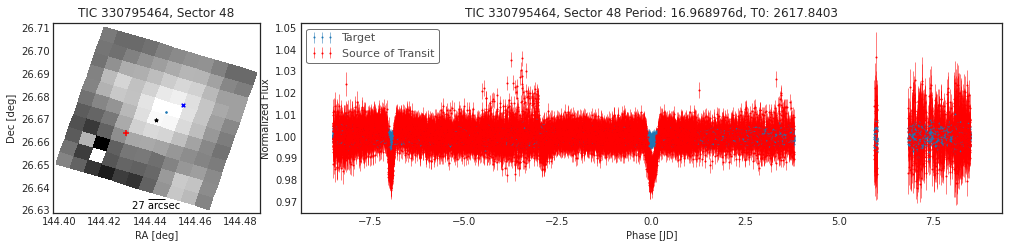

In [14]:
# helper for getting proper motion corrected coordinates
import lightkurve.interact
from astropy import units as u 
from astropy.time import Time
def get_corrected_coordinate(ra, dec, epoch, pm_ra, pm_dec, pm_unit, at_time):
    ra_corrected, dec_corrected, pm_corrected = lightkurve.interact._correct_with_proper_motion(
            ra * u.deg, dec *u.deg,
            pm_ra * pm_unit, pm_dec * pm_unit,
            # e.g., equinox 2000 is treated as J2000 is set to be noon of 2000-01-01 TT
            Time(epoch, format="decimalyear", scale="tt") + 0.5,
            at_time)
    return ra_corrected.to(u.deg).value,  dec_corrected.to(u.deg).value, pm_corrected

mas = u.milliarcsecond / u.year

# Compare with coordinates on ExoFOP

fig = ct.contaminante._make_plot(tpfs[-1], result[-1])
ax0 = fig.axes[0]
# ax0.set_xlim(171.550, 171.580)
# ax0.set_ylim(38.205, 38.235)

# from ExoFOP:
# https://exofop.ipac.caltech.edu/tess/target.php?id=330795464
target_ra, target_dec, pm_corrected = get_corrected_coordinate(144.454766, 26.676403, 2015.5, -53.6776, -15.4206, mas, tpfs[-1].time[0])
label_suffix = " (ExoFOP)"
ax0.scatter([target_ra], [target_dec], c="blue", marker="x", s=13, label=tpfs[-1].meta.get("OBJECT") + label_suffix)
ax0.legend()


# Contamination candidate: from ExoFOP
# https://exofop.ipac.caltech.edu/tess/target.php?id=330795465
nearby_ra, nearby_dec, nearby_pm_corrected = get_corrected_coordinate(144.442561, 26.669811, 2015.5, 0.078562, 0.318719, mas, tpfs[-1].time[0])
nearby_label = "TIC 330795465 (ExoFOP)"

ax0.scatter([nearby_ra], [nearby_dec], c="black", marker="*", s=13, label=nearby_label)
ax0.legend()

ax0.legend().set_visible(False)

print("Target Proper motion corrected:", pm_corrected)
print("Nearby Star Proper motion corrected:", nearby_pm_corrected)

In [15]:
for r in result:
    print("Sector", r["target_lc"].sector, " centroid shift:", r.get("centroid_shift"))

Sector 48  centroid shift: (<Quantity 72.58138142 arcsec>, <Quantity 6.42358281 arcsec>)


Aperture used by `contaminante`:

if a large aperture is chosen for contaminator, transit depth from `contaminante` would be shallower

For sector  48


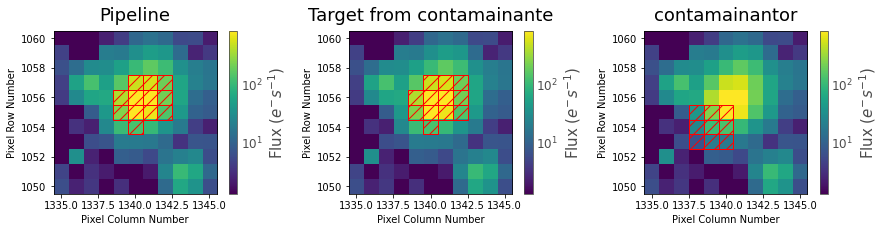

In [16]:
import matplotlib.pyplot as plt

idx = -1 # the sector to show
print("For sector ", result[idx]["target_lc"].sector, )

# fig, ax = plt.subplots(1, 2, figsize=(10, 3))
# tpfs[idx].plot(aperture_mask=tpfs[idx].pipeline_mask, scale='log', ax=ax[0], title='Pipeline')
# tpfs[idx].plot(aperture_mask=result[idx]['contaminator_aper'], scale='log', ax=ax[1], title='contamainante');

fig, ax = plt.subplots(1, 3, figsize=(15, 3))
tpfs[idx].plot(aperture_mask=tpfs[idx].pipeline_mask, scale='log', ax=ax[0], title='Pipeline')
tpfs[idx].plot(aperture_mask=result[idx]['target_aper'], scale='log', ax=ax[1], title='Target from contamainante')
tpfs[idx].plot(aperture_mask=result[idx]['contaminator_aper'], scale='log', ax=ax[2], title='contamainantor');

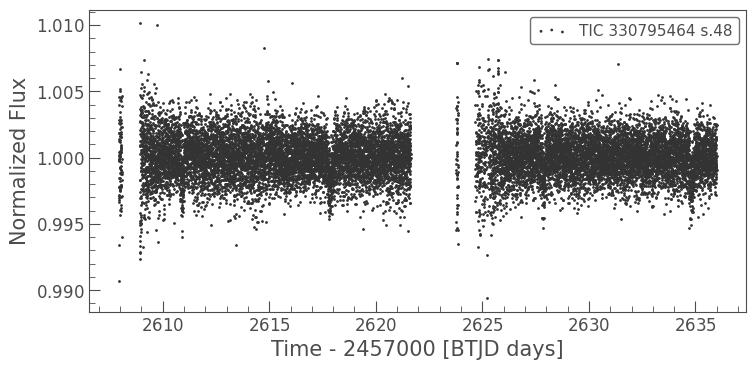

In [20]:
for r in result:
    lc = r.get("target_lc")
    if lc is not None:
        ax = lc.scatter(label=f"{lc.label} s.{lc.sector}");
#         ax.set_ylim(0.99, 1.005); #  consistent y-scale with the next one for 
    else:
        print(f"No target lc")

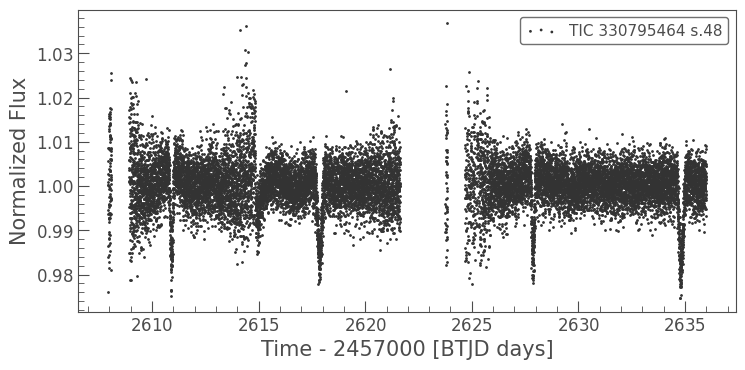

In [19]:
for r in result:
    lc = r.get("contaminator_lc")
    if lc is not None:
        ax = lc.scatter(label=f"{lc.label} s.{lc.sector}");
#         ax.set_ylim(0.99, 1.005);
    else:
        print(f"Sector {r['target_lc'].sector} has no contaminator lc")

In [ ]:
# helper to interactively inspect the pixels around t0
tpf_trunc = tpfs[idx]
tpf_trunc = tpf_trunc[(t0 - 0.75 <= tpf_trunc.time.value) & (tpf_trunc.time.value <= t0 + 0.75)]
tpf_trunc.interact(notebook_url=notebook_url);

Transit signficance at pixel level: to visualize where the dip comes from

For sector  48


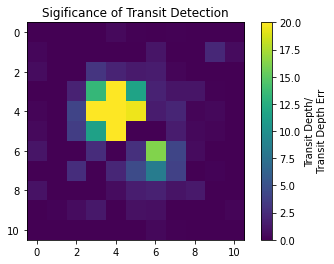

In [21]:
print("For sector ", result[idx]["target_lc"].sector, )

plt.imshow(result[idx]['transit_depth']/result[idx]['transit_depth_err'], vmin=0, vmax=20)
plt.title("Sigificance of Transit Detection")
cbar = plt.colorbar()
cbar.set_label("Transit Depth/\n Transit Depth Err")

In [22]:
from astropy import units as u 
from IPython.display import HTML

def show_tpf_orientation(tpf):
    """ "Helper to visualize the TPF's orientation in the sky. Requires IPython.
    Long arm is north, short arm with arrow is east.
    """
    coord_bottom_left = tpf.wcs.pixel_to_world(0, 0)
    coord_upper_right = tpf.wcs.pixel_to_world(tpf.shape[2] - 1, tpf.shape[1] - 1)
    coord_upper_left = tpf.wcs.pixel_to_world(0, tpf.shape[2] - 1)
    deg_from_north = coord_bottom_left.position_angle(coord_upper_left).to(u.deg).value

    display(
        HTML(
            f"""<div style="position: relative; margin-left: 16px;height: 64px;">
    <div title="Long arm: North; Short arm with arrow: East"
         style="float: left; max-width: 64px;font-size: 32px;margin: 16px;\
transform: rotate({-deg_from_north}deg);transform-origin: left; cursor:pointer;">↳</div>
        <div style="font-family: monospace;">Upper right offset from bottom left - <br>
        RA: {(coord_upper_right.ra - coord_bottom_left.ra).to(u.arcmin):0.6},
        Dec: {(coord_upper_right.dec - coord_bottom_left.dec).to(u.arcmin):0.6}
        </div>
    </div>"""
        )
    )

In [23]:
show_tpf_orientation(tpfs[idx])
tpfs[idx].interact_sky(notebook_url=notebook_url, magnitude_limit=20);

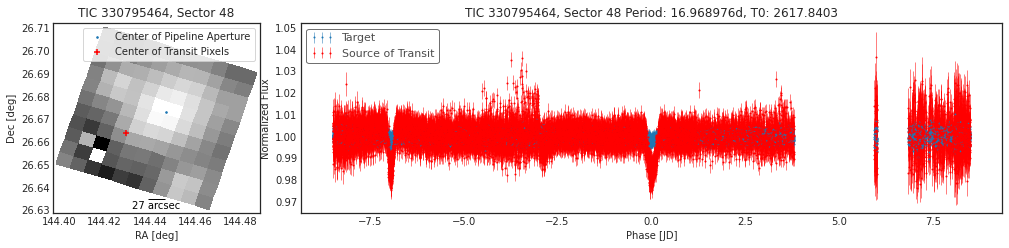

In [24]:
# to compare the with transit centroid from contaminate
result[idx]["fig"]

Using `contaminante` we can see two pieces of evidence that this target is contaminated.
1. There is a significant offset between the center of the **target** (blue dot) in the image, and the **source of the transiting signal** (red dot). **NOTE: The blue dot is the weighted average of the flux inside the pipeline aperture, for crowded sources this may not be accurate.**
2. There is a significant difference between the **target** phase curve (blue phase curve) and the **source of the transiting signal** phase curve (red phase curve).

We name the source of the transiting signal that `contaminante` finds the "contaminator".

The result is a list of dictionaries contains the depth and positions of the target and the "contamintor" for each quarter, including errors. The user is encouraged to 1) look at the phase curves 2) look at the positions of the contaminator and target and 3) the transit depths of the contaminator and the target before claiming that a target is contaminated. In the above cases there is a significant difference between the contaminator and the target.

## Usage notes

1. **Different quarters, campaigns and sectors.** If a target has multiple quarters, campaigns or sectors you can expect each dataset to have some slight offset, due to the target falling on different pixels.

2. **Shallower contaminator light curves.** `Contaminante` looks at each pixel individually to see if there is a significant transit signal. Because faint pixels can contribute a transiting signal at a lower, less significant level, some faint pixels can be missed in contaminante. In the case that the contaminator light curve is **shallower** than the target light curve, it is likely that some faint pixels have been missed from the optimum aperture. This does not indicate that there is any contamination.

